# What we will do


During this session, we will learn how to open, read and handle climate dataset, analyzing the total precipitation avarage worldwide during the month of July 2023.

In order to do this, we will use a dataset provided by the Copernicus Data Store: click the link https://cds.climate.copernicus.eu/cdsapp#!/search?type=dataset and select the dataset named **ERA5 monthly averaged data on single levels from 1940 to present**.

Click on the "Download data" tab and select these options:  
* Product type: Monthly averaged reanalysis  
* Popular: Total precipitation  
* Year: 2023  
* Month: July  
* Time: 00:00  
* Format: NetCDF  

At the end check the “Terms of use” and then click on “Submit form” button.


Download the dataset and save it in the same folder of your python notebook.

# Importing the libraries

Here are the libraries we need for our analysis.

Probably you need to install these  libreries with `pip install` command.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
pip install numpy xarray matplotlib --quiet

Note: you may need to restart the kernel to use updated packages.


In [3]:
import xarray as xr
from matplotlib import pyplot as plt

# %matplotlib inline necessary for getting your plot embedded within the notebook, rather than in a separate window or output cell
%matplotlib inline
plt.rcParams['figure.figsize'] = (8,5) # This line initializes a new figure for plotting with a specified size of 8 inches in width and 5 inches in height.

# Xarray library

Xarray is a library used to handle multi-dimensional arrays, as in the case of the netCDF files.

Here you can find the documentation and a gallery of its potential usage:

* https://docs.xarray.dev/en/latest/howdoi.html
* https://docs.xarray.dev/en/latest/gallery.html



## Xarray data structures
Xarray has 2 fundamental data structures:

* DataArray, that stores a single multi-dimensional variable and its coordinates
* Dataset, that stores multiple variables and their coordinates

## DataArray

A DataArray has 4 essential attributes:

* values: the array of values
* dims: the dimension names for each axis
* coords: the coordinates of each point
* attrs: the metadata

Let’s see how Xarray works by creating a DataArray

In [4]:
da = xr.DataArray([25, 28, 33, 26, 30])
print(da)

<xarray.DataArray (dim_0: 5)> Size: 40B
array([25, 28, 33, 26, 30])
Dimensions without coordinates: dim_0


The dimension of the array is 5, let's assing a name instead of the default one `dim_0`.

In [5]:
da = xr.DataArray([25, 28, 33, 26, 30], dims=['long'])
print(da)

<xarray.DataArray (long: 5)> Size: 40B
array([25, 28, 33, 26, 30])
Dimensions without coordinates: long


We can add coordinates to this dimension:

In [6]:
da = xr.DataArray([25, 28, 33, 26, 30],
                  dims=['long'],
                  coords={'long': [10, 20, 30, 40, 50]})
print(da)

<xarray.DataArray (long: 5)> Size: 40B
array([25, 28, 33, 26, 30])
Coordinates:
  * long     (long) int64 40B 10 20 30 40 50


The coordinates are also used to create indexes, which have the same use as indexes in Pandas:

In [7]:
print(da.indexes)

Indexes:
    long     Index([10, 20, 30, 40, 50], dtype='int64', name='long')


To create plots with Xarray, we use the built-in method `.plot()`: this method automatically generates a plot based on the dimensions and data of the DataArray (to learn more https://docs.xarray.dev/en/latest/user-guide/plotting.html)

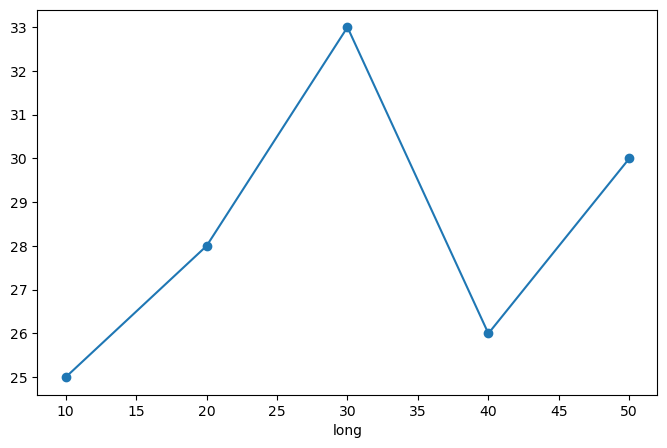

In [8]:
da.plot(marker='o')   # marker = 'o' specifies that each data point should be marked with a circle

Now that we have become a bit more familiar with these new library and their structures, let's work with real data.

# Loading and exploring the data

To open and read our dataset we use the method `.open_dataset()`

In [9]:
dset = xr.open_dataset("ESOTC_global_temperature_indicator_2023.nc")
print(dset)

<xarray.Dataset> Size: 8MB
Dimensions:    (longitude: 1440, latitude: 721, time: 1)
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 8B 2023-07-01
Data variables:
    tp         (time, latitude, longitude) float64 8MB ...
Attributes:
    Conventions:  CF-1.6
    history:      2024-05-29 18:33:11 GMT by grib_to_netcdf-2.28.1: /opt/ecmw...


The output of the `print` command returns a preview of the dataset contents: the dimensions, the coordinates, the variables and the attributes.

We can inspect them in more details:

In [10]:
# Print global attributes
print("Global Attributes:")
print(dset.attrs)

Global Attributes:
{'Conventions': 'CF-1.6', 'history': '2024-05-29 18:33:11 GMT by grib_to_netcdf-2.28.1: /opt/ecmwf/mars-client/bin/grib_to_netcdf -S param -o /cache/data9/adaptor.mars.internal-1717007591.2225747-10030-9-6c0aec14-7d12-4bd5-87f3-db38ec5327fb.nc /cache/tmp/6c0aec14-7d12-4bd5-87f3-db38ec5327fb-adaptor.mars.internal-1717007590.8509223-10030-9-tmp.grib'}


In [11]:
# Print attributes of each variable
print("Variables and their Attributes:")
for var in dset.data_vars:
    print(f"{var}:")
    print(dset[var].attrs)

Variables and their Attributes:
tp:
{'units': 'm', 'long_name': 'Total precipitation'}


So we can see that the variable `tp` is the total precipitation we want to analyze, and it is expressed in meters.

In [12]:
print(dset['tp'])

<xarray.DataArray 'tp' (time: 1, latitude: 721, longitude: 1440)> Size: 8MB
[1038240 values with dtype=float64]
Coordinates:
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * time       (time) datetime64[ns] 8B 2023-07-01
Attributes:
    units:      m
    long_name:  Total precipitation


## 👉 Now it's your turn


1.   What is the time dimension, and which date does it correspond to?
2.   What does the number 1038240 correspond to, and how is it calculated?
3.   Have you noticed the values for latitude (721) and longitude (1440)? They seem inconsistent with the range of values we know: -90° to 90° for latitude and -180° to 180° for longitude. How do you explain this?





🆘 solution

1. the data array `tp` has only one time step (one temporal record) and correspond to the date July 1st, 2023.
2. The count of 1038240 values matches the product of the dimensions: 1 (time) × 721 (latitude) × 1440 (longitude), which totals 1,038,240. Each of these values represents a float32 data point, indicating the total precipitation recorded at each geographic coordinate for the given time.
3. The longitude value 1440 degrees implies that the dataset covers longitude from -180 to +180 degrees at a resolution of about 0.25 degrees (360/1440 = 0.25 degrees). The same logic can be applied to the latitude: 721 suggests that the dataset covers latitude from the South Pole to the North Pole at a resolution of about 0.25 degrees (360/720 = 0.5 degrees for half the globe)

# Visualize the data

Now it's time to represent the content of this dataset in a more immediate way, and to do this, we use the `.plot()` method.

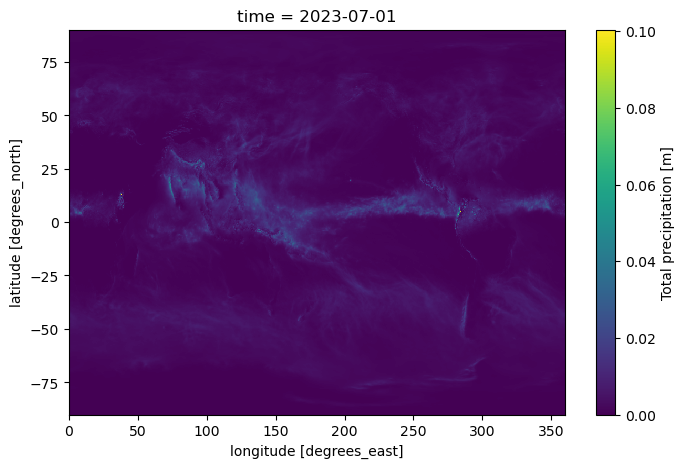

In [13]:
dset['tp'].plot()

This basic version of the plot shows how precipitation values are distributed spatially, but honestly, it is not very informative for those viewing it. How can we improve its readability?   
The precipitation values are expressed in meters, so we can set a threshold at scale of 0.02 and change the default color map.

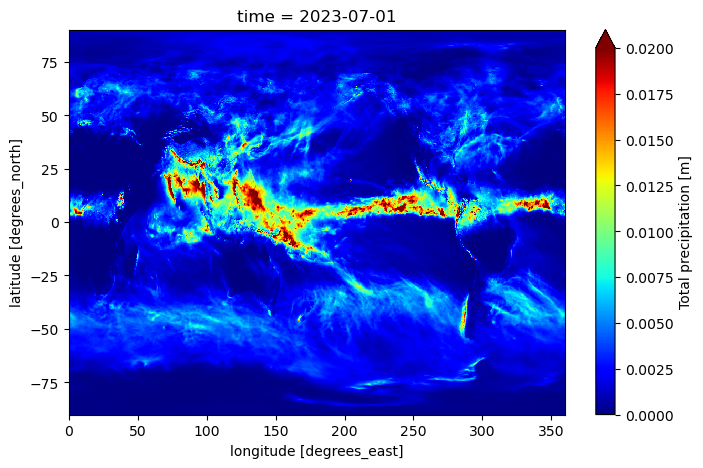

In [14]:
dset['tp'].plot(cmap='jet', vmax=0.02)

`cmap='jet'`: cmap parameter specifies the colormap used to represent the data. The 'jet' colormap is a popular choice in scientific visualization and includes a spectrum from blue to red, passing through cyan, yellow, and orange. Blue typically represents lower values, while red represents higher values.

`vmax=0.02`: this parameter sets the maximum value of the colormap. Any data value that is 0.02 or higher will be colored with the maximum color (red in the case of 'jet'). This is useful for standardizing the color scale across multiple plots or for emphasizing a specific range of data. It ensures that all values at or above 0.02 are highlighted similarly, which can help in identifying areas of heavy precipitation if 0.02 is considered significant.

The result of this second version of the chart is definitely clearer and more interpretable. But let's try to further customize it by defining a scale of shades of blue, and modifying the title and the axis labels.

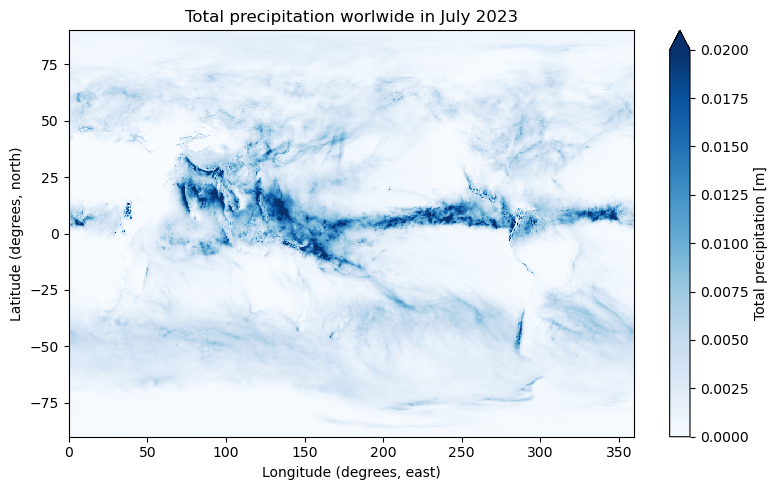

In [15]:
dset['tp'].plot(cmap=plt.cm.Blues, vmax=0.02)
plt.title("Total precipitation worlwide in July 2023")
plt.ylabel("Latitude (degrees, north)")
plt.xlabel("Longitude (degrees, east)")
plt.tight_layout()
plt.draw()

The `.tight_layout()` function from Matplotlib is used to automatically adjust the plot parameters such as the sizes and positions of subplots, axis labels, titles, and legends so that they fit nicely in the plot window.

The `draw()` function is used to update a figure after it has been altered but not automatically re-rendered.

# Create a map

This version of the chart also has interpretive difficulties: it shows precipitation by latitude and longitude, but it would be much easier if we could see it associated with a map.

To do it, we will use a very powerful Cartographic library name cartopy (here the link to the documentation https://scitools.org.uk/cartopy/docs/latest/)

We need to install and import it:

In [16]:
pip install cartopy --quiet

Note: you may need to restart the kernel to use updated packages.


In [17]:
import cartopy.crs as ccrs

And now we can proceed using one of the projection provided by the library.


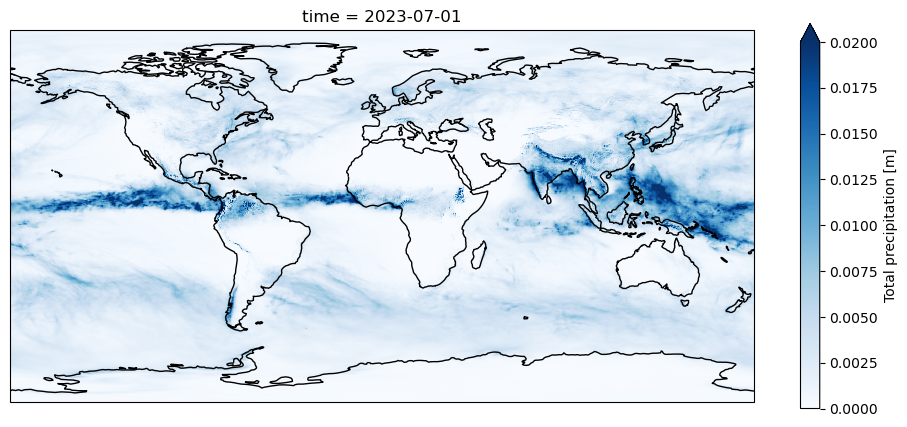

In [18]:
fig = plt.figure(figsize=[12,5])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0)) # Adds a subplot to the figure. The `111` argument indicates that there is one row, one column, and this is the first subplot.
dset['tp'].isel(time=0).plot(ax=ax, cmap=plt.cm.Blues, vmax=0.02,
                   transform=ccrs.PlateCarree())
ax.coastlines()
plt.show()

Let's examine the code line by line:

1. `fig = plt.figure(figsize=[12,5])`: initializes a new figure for plotting with a specified size of 12 inches in width and 5 inches in height.

2. `ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=0))`: adds a subplot to the figure. The `111` argument indicates that there is one row, one column, and this is the first subplot.  
The subplot uses a specific projection called `PlateCarree`.  
`central_longitude=0` sets the central longitude of the map projection to 0 degrees, i.e. the Greenwich Meridian.

3. `dset['tp'].isel(time=0).plot(ax=ax, cmap=plt.cm.Blues, vmax=0.02, transform=ccrs.PlateCarree())`:  
`dset['tp']` accesses the total precipitation variable.  
`.isel(time=0)` selects the first time step from the dataset using index-based selection.  
At the method `.plot()` we need to add the new argument `transform=ccrs.PlateCarree()` to properly align the data with the map projection.

4. `ax.coastlines()`: adds coastlines to the map, helping to delineate major geographic features like continents and islands.

5. `plt.show()`: displays the plot.

In this new chart, however, we have lost the x (longitude) and y (latitude) axis values and, by setting the 0°  longitude in a central position, the chart has been shifted compared to our previous visualizations.

Let's see how to adjust the longitude tick labels so that they properly start at 0 and do not include 360 (which effectively is the same position as 0 on the map).

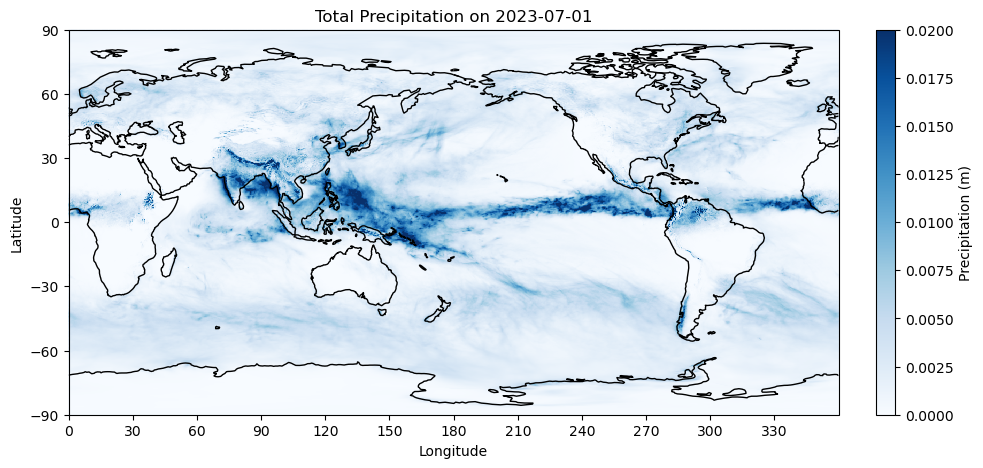

In [19]:
fig = plt.figure(figsize=[12, 5])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=180))
tp_data = dset['tp'].isel(time=0)


im = tp_data.plot(ax=ax, cmap=plt.cm.Blues, vmax=0.02,
                  transform=ccrs.PlateCarree(), add_colorbar=False)  # Turn off default colorbar
ax.coastlines()
ax.set_global()  # Ensure the map spans from -180 to 180 when central_longitude is 180

ax.set_yticks(range(-90, 91, 30), crs=ccrs.PlateCarree())  # Set y-ticks every 30 degrees

# Adjust the x-ticks for 0 to 360 display
new_ticks = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]
adjusted_ticks = [(x - 180) % 360 - 180 for x in new_ticks]  # Adjust ticks to match the central_longitude
ax.set_xticks(adjusted_ticks, crs=ccrs.PlateCarree())  # Set x-ticks

ax.set_xticklabels(new_ticks)  # Label ticks as we want them to appear
ax.set_xlabel('Longitude')  # Set x-axis label
ax.set_ylabel('Latitude')  # Set y-axis label
ax.set_title(f"Total Precipitation on {str(tp_data.time.values)[:10]}")

# Adding the colorbar manually
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Precipitation (m)')  # Set colorbar label

plt.show()

# Select an AOL - Area of Location

Now we want to create a map that focuses specifically on Europe, so we will need to adjust the geographical extent to zoom in on Europe. We can do it defining a specific bounding box for Europe.

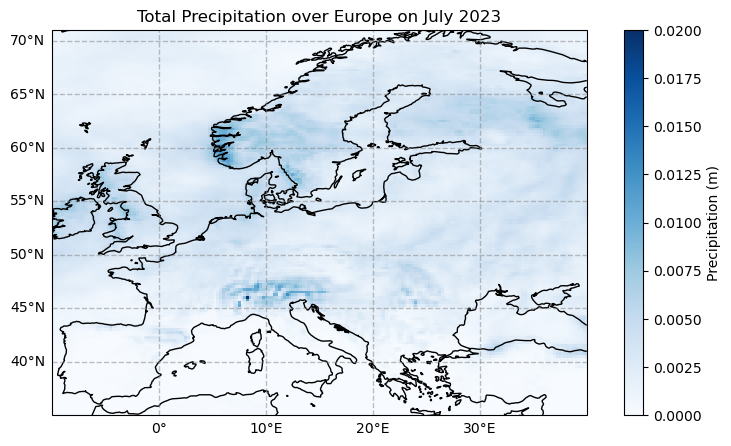

In [20]:
# latitude and longitude ranges for Europe
lat_min = 35
lat_max = 71
lon_min = -10
lon_max = 40

fig = plt.figure(figsize=[12, 5])
ax = fig.add_subplot(111, projection=ccrs.PlateCarree(central_longitude=10)) # 10 degrees is a central longitude that fits well for Europe.
tp_data = dset['tp'].isel(time=0)
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
im = tp_data.plot(ax=ax, cmap=plt.cm.Blues, vmax=0.02,
                  transform=ccrs.PlateCarree(), add_colorbar=False)

ax.coastlines(resolution='50m')

# Adding gridlines and mute labels
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False

# Adding the colorbar manually
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.046, pad=0.04)
cbar.set_label('Precipitation (m)')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Total Precipitation over Europe on July 2023')

plt.show()

`orientation='vertical'`: This sets the orientation of the colorbar. Here, it's vertical, meaning the colorbar will be displayed vertically, typically to the right of the plot.  
`fraction=0.046`: This parameter controls the size of the colorbar relative to the axes. The value 0.046 means the colorbar will take up approximately 4.6% of the axes' width (for a vertical colorbar) or height (for a horizontal colorbar).  
`pad=0.04`: This sets the space between the colorbar and the axes. The value 0.04 means there will be a space equal to 4% of the axes' width (for a vertical colorbar) or height (for a horizontal colorbar) between the axes and the colorbar.

# 3D Visualization

Cartopy provides projections that allow three-dimensional visualizations. Therefore, let's use the Orthographic projection to create a globe-like view centered on Europe.

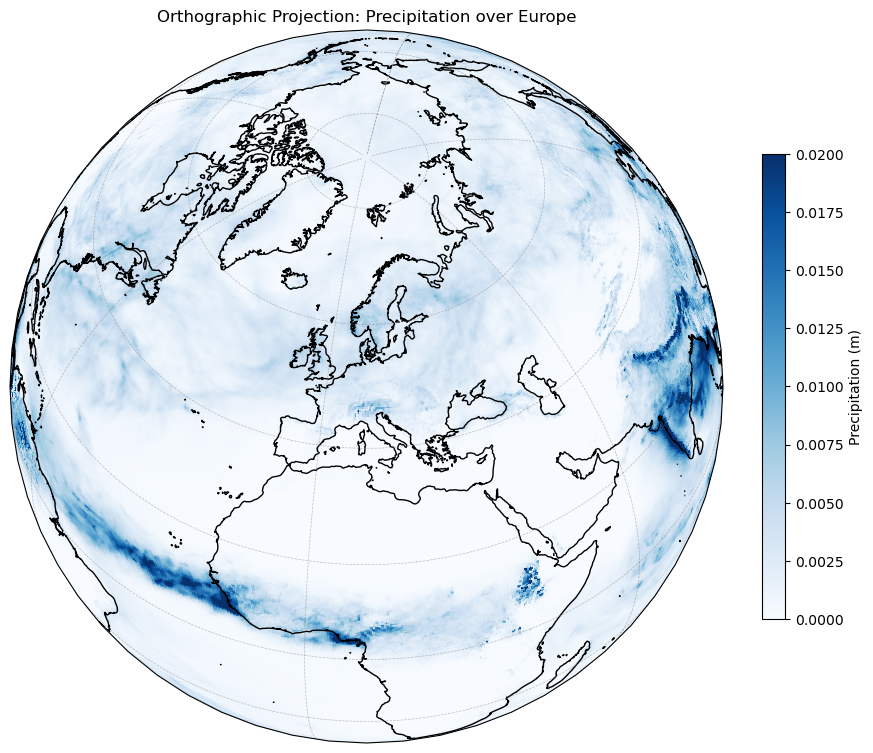

In [21]:
fig = plt.figure(figsize=[10, 10])  # Square figure for the spherical look

# Set up the Orthographic projection centered on a point that best views Europe
ax = fig.add_subplot(111, projection=ccrs.Orthographic(central_longitude=10, central_latitude=50))

# Select the variable and the time step
tp_data = dset['tp'].isel(time=0)

# Plotting the data, ensure the transformation is specified correctly for this projection
im = tp_data.plot(ax=ax, cmap=plt.cm.Blues, vmax=0.02,
                  transform=ccrs.PlateCarree(), add_colorbar=False)

# Set global extent to show the globe appearance
ax.set_global()

ax.coastlines(resolution='50m')
gl = ax.gridlines(draw_labels=False, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
cbar = plt.colorbar(im, ax=ax, orientation='vertical', fraction=0.03, pad=0.05)
cbar.set_label('Precipitation (m)')

ax.set_title('Orthographic Projection: Precipitation over Europe')

plt.show()